# Syetem Architecture

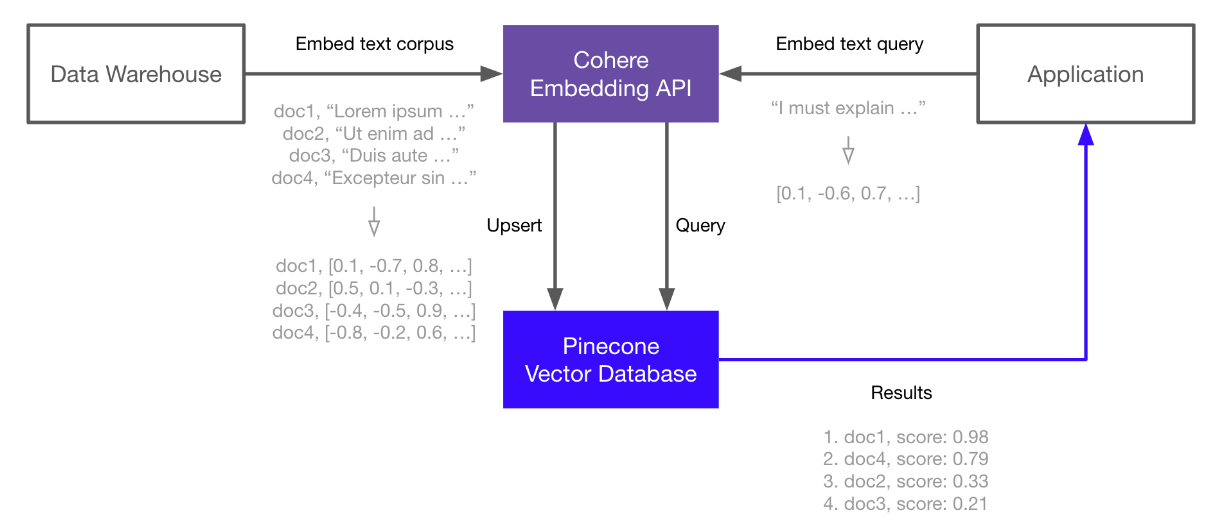

In [12]:
!pip install cohere

In [13]:
import os
import json
import yaml
import torch
import cohere
import pinecone
import transformers
from sys import getsizeof
from datasets import load_dataset

In [30]:
with open('cadentials.yaml') as f:
    credentials = yaml.load(f, Loader=yaml.FullLoader)

os.environ['PINECONE_API_KEY'] = credentials['PINECONE_API_KEY']
os.environ['COHERE_API_KEY'] = credentials['COHERE_API_KEY']

pinecone.init(
            api_key=credentials['PINECONE_API_KEY'],
            environment="us-west4-gcp"  # find next to API key in console
        )
cohere_ = cohere.Client(os.environ['COHERE_API_KEY'])

In [15]:
trec = load_dataset('trec', split='train[:1000]')
trec

Found cached dataset trec (C:/Users/Legion/.cache/huggingface/datasets/trec/default/2.0.0/f2469cab1b5fceec7249fda55360dfdbd92a7a5b545e91ea0f78ad108ffac1c2)


Dataset({
    features: ['text', 'coarse_label', 'fine_label'],
    num_rows: 1000
})

In [16]:
limit = 0

for record in trec['text']:
    size = getsizeof(json.dumps(record))
    if size > 40_000:
        limit += 1

print(f"Over 40KB: {round((limit/len(trec['text'])*100),2)}%")

Over 40KB: 0.0%


# STEP 01 : Generate Embeddings

In [20]:
def generate_and_store_embeddings(
                                text, 
                                batch_size = 12,
                                index_name = 'cohere-semantic-search'
                                ):
    embeds = cohere_.embed(
                        texts=text,
                        model='small',
                        truncate='LEFT'
                        ).embeddings
    embeds_tensor = torch.tensor(embeds)
    ids = [str(i) for i in range(len(embeds))]
    meta = [{'text': trec['text'][i]} for i in range(len(embeds))]

    if (index_name not in pinecone.list_indexes()):
        print('Creating index ...'.format(index_name))
        pinecone.create_index(
                            index_name,
                            dimension=embeds_tensor.shape[1],
                            metric='cosine',
                            metadata_config={'indexed': ['docs']}
                            )
        
    index = pinecone.Index(index_name)
    for i in range(0, len(embeds), batch_size):
        i_end = min(i+batch_size, len(embeds))
        print('Storing batch {} ...'.format(i))
        index.upsert(list(zip(ids[i:i_end], embeds[i:i_end], meta[i:i_end])))

    return index

index = generate_and_store_embeddings(trec['text'])
index.describe_index_stats()

Storing batch 0 ...
Storing batch 12 ...
Storing batch 24 ...
Storing batch 36 ...
Storing batch 48 ...
Storing batch 60 ...
Storing batch 72 ...
Storing batch 84 ...
Storing batch 96 ...
Storing batch 108 ...
Storing batch 120 ...
Storing batch 132 ...
Storing batch 144 ...
Storing batch 156 ...
Storing batch 168 ...
Storing batch 180 ...
Storing batch 192 ...
Storing batch 204 ...
Storing batch 216 ...
Storing batch 228 ...
Storing batch 240 ...
Storing batch 252 ...
Storing batch 264 ...
Storing batch 276 ...
Storing batch 288 ...
Storing batch 300 ...
Storing batch 312 ...
Storing batch 324 ...
Storing batch 336 ...
Storing batch 348 ...
Storing batch 360 ...
Storing batch 372 ...
Storing batch 384 ...
Storing batch 396 ...
Storing batch 408 ...
Storing batch 420 ...
Storing batch 432 ...
Storing batch 444 ...
Storing batch 456 ...
Storing batch 468 ...
Storing batch 480 ...
Storing batch 492 ...
Storing batch 504 ...
Storing batch 516 ...
Storing batch 528 ...
Storing batch 540 ..

{'dimension': 1024,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 1000}},
 'total_vector_count': 1000}

In [32]:
def cohere_search(
                query,
                top_k = 10,
                index_name = 'cohere-semantic-search'
                ):
    index = pinecone.Index(index_name)
    embeds = cohere_.embed(
                        texts=[query],
                        model='small',
                        truncate='LEFT'
                        ).embeddings
    
    results = index.query(
                        embeds,
                        top_k=top_k,
                        include_metadata=True
                        )
    return results

In [34]:
results = cohere_search('What cased the 1929 great depression?')
for match in results['matches']:
    print(f"{match['score']:.2f}: {match['metadata']['text']}")

0.74: When was `` the Great Depression '' ?
0.72: Why did the world enter a global depression in 1929 ?
0.40: What crop failure caused the Irish Famine ?
0.30: When did the Dow first reach ?
0.30: What is considered the costliest disaster the insurance industry has ever faced ?
0.26: What were popular songs and types of songs in the 1920s ?
0.26: What caused the Lynmouth floods ?
0.25: When was the San Francisco fire ?
0.24: What war did the Wanna-Go-Home Riots occur after ?
0.24: When did World War I start ?
